# A/B Testing: Determine Sample Size

<img src="pic/AB-Testing.png">

One important up front activity in A/B Testing is to figure out the sample size you need. This is a crucial, since it significantly impacts the cost of your study and the reliability of your results. Collect too much sample: you’ve wasted money and time. Collect too little: your results may be useless.

## Scenario

Assume that now you want to rebrand your boba tea store by attracting more teenagers. You want to accomplish this goal by changing the design of the signboard to be more modern. You're planning on collecting the data before and after you change the signs and determine if there's a difference.

---
## Hypothesis 

To understand whether or not this change can actually attract teenagers, we need to set up statistical tests to examine the result. Here let's set the null hypothesis and alternative hypothesis as follows:

**Null Hypothesis**: The proportion of teenagers entering to the boba tea store using old signboard is the same as using the new redesigned signboard. This can be formulated as 
$$p_1 = p_2$$
where $\sigma$ is the proportion of teenagers entering in scenario 1 and 2.

**Alternative Hypothesis**: The proportion of teenagers entering to the boba tea store using old signboard is not the same as using the new redesigned signboard. This can be formulated as
$$p_1 \neq p_2$$

This set of null hypothesis and alternative hypothesis is in fact specifically for the Student’s t test. 

The test is often interpreted using a **p-value**, which is the probability of observing the result given that the null hypothesis is true.

**p-value (p)**: Probability of obtaining a result equal to or more extreme than was observed in the data.

In interpreting the p-value of a significance test, you must specify a significance level ($\alpha$). A common value for the significance level is 5% written as 0.05.

---
## Mathematical Formulation

In most cases, the number of samples between the controlled group and the treatment group won't be the same. Thus, here we will introduce some **pooled version** definition.

$$\hat{p} = \frac{n_1p_1+n_2p_2}{n_1+n_2}$$

where $\hat{p}$ is the pooled probability of successes for the controlled group and treatment group as a whole.

$$SE = \sqrt{\hat{p}(1-\hat{p})(\frac{1}{n_1}+\frac{1}{n_2})}$$

where SE is the standard error for the confidence interval.

Let's define a function for the **Null Hypothesis**.
$$\hat{d} = \sigma_1 - \sigma_2$$
where d ~ N(0,SE)

$$Z = \frac{\hat{d}}{SE} = \frac{p_1 - p_2}{\sqrt{\hat{p}(1-\hat{p})(\frac{1}{n_1}+\frac{1}{n_2})}}$$

---
## How does sample size matter?

Before jumping into the topic right away, let's first define some of the terms used in statistical testing.
* $\alpha$: Probability for **rejecting the null hypothesis** when the **null hypothesis is true**. This is also known as **Type I error** or **false positive**.
* $\beta$: Probability for **failing to reject the null hypothesis** when **the null hypothesis is in fact false**. This is also known as **Type II error** or **false negative**.
* **Sensitivity** or **Power**: 1 - $\beta$. In general, people often choose 80% as the threshold for sensitivity.

Why does sample size matter?

* If you collect small number of sample:
You will have **lower Alpha but higher Beta**. That is, you are unlikely to launch a bad experiment, but **you are likely to fail to launch an experiment that actually have the difference you care about**. 

In practice, you want your experiment to have a high level of sensitivity at the practical significant boundary. 

* If you collect more number of sample:
You will get **the same Alpha but lower Beta**. That is, you will **have a lower chance of failing to reject the null hypothesis when there is actually some changes**. 

In short, when interpreting statistical power, we seek experiential setups that have high statistical power so that we will have a smaller risk of committing Type II error (false negative).


### Size / Power Trade-off

There is another interesting topic about the trade-off between size and power. That is, **The smaller the change you want to detect, or the increased confidence you want to have in the result, means you have to run a larger experiment.** Running a larger experiment can inevitably take more time. Thus, there's a trade-off between the two.


---
## Find the Sample Size Needed
So how exactly can we find the sample size we need? In fact we can first refer to the formula below again:

$$Z = \frac{p_1 - p_2}{\sqrt{\hat{p}(1-\hat{p})(\frac{1}{n_1}+\frac{1}{n_2})}}$$

We can see that if we want to determine the sample size n1, n2, we need to consider the following factors:

* **The confidence level ($\alpha$)**: How confident do we need to be to ensure the results didn’t occur by chance? For a given difference in results, **detecting it with higher confidence requires more sample**. Common choices here include 95% or 99% confidence.


* **The level of difference wanted to detect ( $p_1 - p_2$ )**: The smaller the differences you want to be able to detect, the more sample will be required.


* **The probability ( $\hat{p}(1-\hat{p}) $ )**: Standard Error increases when the probability is closer to 0.5 instead of extreme numbers. Thus, say you have a probability greatly lower than 0.5. If you want to test for a higher probability, you should increase the number of page views to have the same Standard Error.

Here is an awesome online sample size calculator: [Evan's Awesome A/B Tools](https://www.evanmiller.org/ab-testing/sample-size.html).

---
## Calculating Sample Size using Scipy
We need a way of figuring out Z so that we can determine whether a given sample size provides statistically significant results. Thus, let’s define a function that returns the Z value given [$p_1, p_2, n_1, n_2$].

In [16]:
import math
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def z_calc(p1, p2, n1, n2):
    p_star = (p1*n1 + p2*n2) / (n1+n2)
    return((p2 - p1) / math.sqrt(p_star * (1-p_star) * ((1 / n1)+(1 / n2))))

# def z_calc(p1, p2, n1, n2):
#     p_star = (p1*n1 + p2*n2) / (n1 + n2)
#     return (p2 - p1) / math.sqrt(p_star*(1 - p_star)*((1.0 / n1) + (1.0 / n2)))

Then, we can define the function that calculates the sample size needed. To do so, we need to know the prior-probability ($p_1$), the difference in probabilities ($\hat{d}$), and the significance level ($\alpha$).  For simplicity we’ll just assume that $n_1 = n_2$. You can also use your prior knowledge to link $n_1$ and $n_2$ before the experiment. For example, if you know in advance that $n_1$ will have about a quarter of the size of $n_2$, then you can simply have a function linking the relationship. 

In [29]:
def get_sample_size(p1, p2,alpha):
    p_diff = p2 - p1
    if p_diff <= 0:
        raise ValueError("p_diff must be > 0")
    
    n = 1 # assume both have the same sample size
    while True:
        z = z_calc(p1, p2, n1=n, n2=n)
        p = 1 - stats.norm.cdf(z) # get the prob at z
        if p < alpha:
            break
        n += 1
    return(n)

In [31]:
get_sample_size(0.1,0.11,0.05)

5086

In [33]:
get_sample_size(0.1,0.105,0.05)

19912

In [34]:
get_sample_size(0.3,0.305,0.05)

45669

From the tests above we can see conclude that **the number of sample size needed depends on both the level of difference being tested as well as the absolute probability of $p_1$**. Thus, let's do some chart to see how the sample size actually varies.

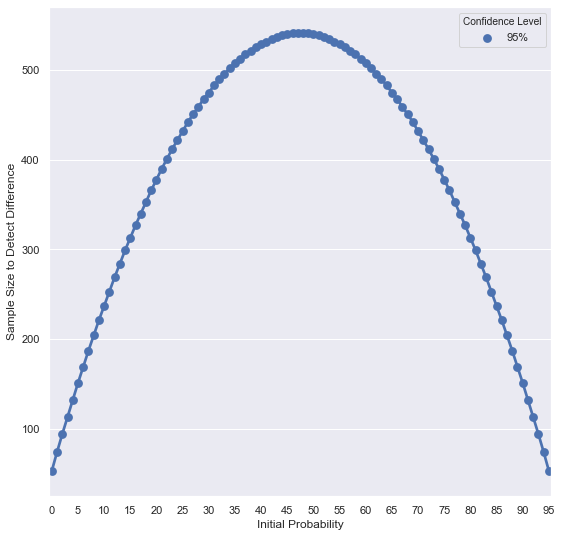

In [39]:
#Map how sample size changes as choice of p1 changes, holding all 
#else constant.

p1s = [x*.01 for x in range(96)]
p_diff = 0.05
records = []
for p1 in p1s:
    record = {}
    record['Probability Difference'] = p_diff
    record['Sample Size to Detect Difference'] = get_sample_size(p1 = p1, p2 = p1 + p_diff, alpha = 0.05)
    record['Confidence Level'] = '95%'
    record['Initial Probability'] = p1 * 100
    records.append(record)
    
df = pd.DataFrame(records)


fig, ax = plt.subplots(figsize=(9, 9))
sns.set(style='darkgrid')

plot = sns.pointplot(x='Initial Probability',
            y='Sample Size to Detect Difference',
            hue='Confidence Level', ax = ax,
            data=df)

labels = []
for i in range(0, 101):
    if i % 5 == 0:
        labels.append(str(i))
    else:
        labels.append('')
plot.set_xticklabels(labels=labels)
plt.show()

It's clear that when $p_1$ and $p_2$ is close to 0.5, it requires the most sample. This is because of the term $\hat{p}(1-\hat{p})$. 

Given Z, the higher the $\hat{p}(1-\hat{p})$, the lower the $\frac{1}{n_1} + \frac{1}{n_2}$, thus the higher the N.

---
## Calculating Sample Size using Statsmodels

Instead of scipy.stats, you can also calculate the sample size using statsmodels. 

In this statsmodels method we need to use another metric called **effect size** to calculate the number of sample needed.

### Why do we need effect size?

The statistical test can only comment on the likelihood that there is an effect. It does **not comment on the size of the effect**. The results of an experiment could be significant, but the effect so small that it has little consequence. It is possible, and unfortunately quite common, for a result to be statistically significant and trivial. It is also possible for a result to be statistically nonsignificant and important.

Thus, an effect size refers to **the size or magnitude of an effect or result as it would be expected to occur in a population**.


It is common to organize effect size statistical methods into groups, based on the type of effect that is to be quantified. Two main groups of methods for calculating effect size are:

* **Association**: Statistical methods for quantifying an association between variables. (e.g. Pearson's correlation)
* **Difference**: Statistical methods for quantifying the difference between variables. (e.g. cohen's d)

In the statsmodels' TTestIndPower, the definition of the parameter effect_size is 

> **effect_size** : `float and positive`. Standardized effect size, difference between the two means divided
>    by the standard deviation. 

which is in fact the definition of the **`cohen's d`**. 

Note that **the effect size does not replace the results of a statistical hypothesis test**. Instead, the effect size complements the test. Ideally, the results of both the hypothesis test and the effect size calculation would be presented side-by-side.

* **Hypothesis Test**: Quantify the **likelihood** of observing the data given an assumption (null hypothesis).
* **Effect Size**: Quantify the **size of the effect** assuming that the effect is present.

Therefore, we can see that there's a difference between the two methods.

The scipy.stats method presented above calculates sample size using **hypothesis testing**, while the statsmodel.stats method uses **effect size**. For here, we will focus only on the **difference** effect size, which is often referred to as the "d family" of effect size methods.

---
### Cohen's d Method

Cohen’s d measures **the difference between the mean from two Gaussian-distributed variables**. It is a standard score that summarizes the difference in terms of the number of standard deviations. Because the score is standardized, you can interpret the result from the table below.

The table below contains descriptors for magnitudes of d = 0.01 to 2.0, as initially suggested by Cohen and expanded by Sawilowsky.

|Effect size|	d	|Reference|
|:---------:|:------:|:-------:|
|Very small|0.01|Sawilowsky, 2009|
|Small|0.20|Cohen, 1988|
|Medium|0.50|Cohen, 1988|
|Large|0.80|Cohen, 1988|
|Very large|1.20|Sawilowsky, 2009|
|Huge|2.0|Sawilowsky, 2009|


### Mathemetical Formulation

The effect size (d) can be defined as the following:
$$ d = \frac{\mu_1 - \mu_2}{s} $$

where s is the pooled standard deviation defined as follows:
$$ s = \sqrt{\frac{(n_1-1)s_1^2+(n_2-1)s_2^2}{n_1+n_2-2}}$$

where the variance for one of the groups is defined as
$$ s_1^2 = \frac{1}{n_1-1} \sum \limits_{i=1}^{n_1}$$

In [4]:
from statsmodels.stats.power import TTestIndPower

In [101]:
def cohend(d1,d2):
    """
    Parameters
    ----------
    d1, d2 : array
        an array of values for the calculation of cohen's d.
    """
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = math.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return((u1 - u2) / s)

In [126]:
# random data
data1 = 10 * np.random.randn(10000) + 60
data2 = 10 * np.random.randn(10000) + 55

# parameters for power analysis
effect_size = cohend(data1, data2)
alpha = 0.05 # significance level
power = 0.90 # 1 - beta. 
# It is the probability that the test correctly rejects the Null Hypothesis if the Alternative Hypothesis is true.

# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect_size = effect_size, nobs1 = None, alpha = alpha, power = power,ratio = 1.0) 
# effect_size : standardized effect size, difference between the two means divided by the standard deviation. 
# nobs1: number of observations of sample 1
# nobs2 = nobs1 * ratio
print(f'Sample Size: {result:.3f}')

Sample Size: 83.661


Let's dive deeper into the parameter for method **analysis.solve_power**.

```python
analysis = TTestIndPower()
result = analysis.solve_power(effect_size = effect, nobs1 = None, alpha = alpha, power = power,ratio = 1.0)
```

**Parameters**

* **nobs1** : number of observations of sample 1.

* **ratio** : the ratio between **number of observations of sample 1** and **number of observations of sample 2**.
    
The number of observations of sample two is ratio times the size of sample 1,
i.e. `nobs2 = nobs1 * ratio`

* **alpha** : significance level $\alpha$
* **power** : 1 - $\beta$

---
The TTestIndPower class also offers a method to plot the relationship for number of samples needed.

Let's do some plot to see the relationship among variables. 

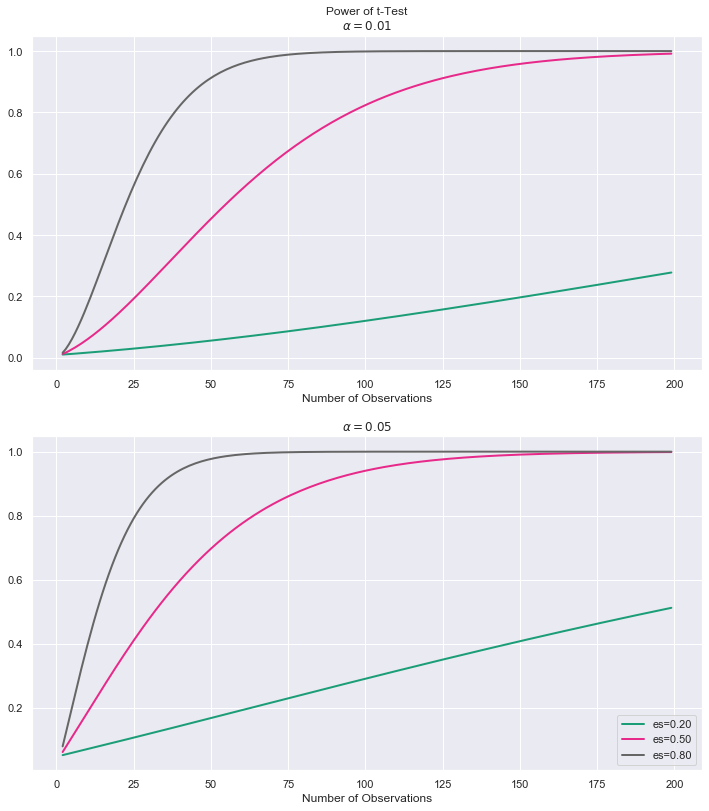

In [129]:
# power vs. number of observations 

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)
fig = TTestIndPower().plot_power(dep_var='nobs',
                                 nobs= np.arange(2, 200),
                                 effect_size=np.array([0.2, 0.5, 0.8]),
                                 alpha=0.01,
                                 ax=ax, title='Power of t-Test' + '\n' + r'$\alpha = 0.01$')
ax.get_legend().remove()
ax = fig.add_subplot(212)
fig = TTestIndPower().plot_power(dep_var='nobs',
                                 nobs= np.arange(2, 200),
                                 effect_size=np.array([0.2, 0.5, 0.8]),
                                 alpha=0.05,
                                 ax=ax, title=r'$\alpha = 0.05$') 
fig.subplots_adjust(top = 1.4)


---
**Reference**:

[Udacity A/B Testing Course](https://www.udacity.com/course/ab-testing--ud257)

[Documentation: scipy.stats.norm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html)

[Wikipedia: Cohen's D Effect Size](https://en.wikipedia.org/wiki/Effect_size#Cohen's_d)

[A Gentle Introduction to Effect Size Measures in Python](https://machinelearningmastery.com/effect-size-measures-in-python/)

[A Gentle Introduction to Statistical Power and Power Analysis in Python](https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/)